In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
import random
from scipy import misc
from functools import reduce
%matplotlib inline

# The Ising Model, Spin Glasses, and Hopfield Networks

## The Hamiltonian

$$\mathcal{H}(\ \vec{s}; J, H) = -\bigg[\sum_{i,\ j}J_{ij} s_i s_j + \sum_i H s_i\bigg]$$

where the $J_{ij}$ are interaction strengths, $s_i = \pm 1$ are spins, and $H$ is the external field strength

As usual, the probability of the system having configuration $\vec{s}$ is given by the Boltzmann distribution

$$p(\vec{s}; J, H) = \frac{\exp[-\beta \mathcal{H}(\vec{s}; J, H)]}{Z}$$

If we have the partition function we can calculate 

$$\langle E \rangle = -\frac{\partial \ln Z}{\partial \beta}, \ \ \ \ var(E) = \frac{\partial^2 \ln Z}{\partial \beta^2}$$

The energy fluctuations are related to the heat capacity

$$C = k_B \beta^2 var(E)$$

## The Ising Model

![Ising Lattice](images/ising_lattice.png)

## The Metropolis-Hastings Algorithm

1. Pick a spin at random.
2. Calculate the energy $\Delta E$ that would be the result of flipping the spin.
3. If $\Delta E \le 0$, flip the spin. Otherwise, flip it with probability $\exp(-\beta \Delta E)$
4. Repeat until you get good statistics

In [4]:
class IsingModel:
    
    def __init__(self, N, J=1.0, spins=None, beta=1.0, H=0.0, periodic=True):
        self.lattice = nx.grid_graph([N,N], periodic=periodic)
        self.lattice = nx.relabel_nodes(self.lattice,
                                        {n : i for i, n in 
                                         enumerate(self.lattice.nodes())})
        self.N = N
        self.H = H
        self.beta = beta
        self.kT = 1 / beta
        self.J  = J
        self._init_spins(spins)
            
    def _init_spins(self, spins):
        if spins is None:
            spins = (2*(np.random.randn(self.N**2) > 0) - 1)
        for n, s in zip(self.lattice, spins):
            self.lattice.node[n]["spin"] = s
            
    def draw_network(self, node_size=300, ax=None):
        dx = 1.0#/ self.N
        pos = {n : map(lambda x: x*dx, n) for n in self.lattice.nodes()}
        if ax is None: fig, ax = plt.subplots()
        colors = ["k" if self.lattice.node[n]["spin"] > 0 
                      else "w" for n in self.lattice] 
        nx.draw_networkx(self.lattice, 
                         pos=pos, node_color=colors, 
                         node_size=node_size, 
                         with_labels=False, 
                         ax=ax)
        ax.set_xlim((0,self.N-1))
        ax.set_ylim((0,self.N-1))
        ax.set_yticks([])
        ax.set_xticks([])
        return ax
    
    def trace(self, N=10**5, thin=1000, burn_in=10**3):
        energies = []
        magnetizations = []
        for j in range(burn_in):
            self.metropolis_hastings_step()
        for i in range(N):
            self.metropolis_hastings_step()
            if i % thin == 0:
                energies.append(self.energy())
                magnetizations.append(self.magnetization())
                
        return {"energy" : np.array(energies), 
                "magnetization" : np.array(magnetizations)}
            
        
    def spin_matrix(self):
        spins = [self.lattice.node[s]["spin"] for s in range(self.N**2)]
        return np.reshape(spins, (self.N, self.N))
    
    def draw(self, ax=None):
        M = self.spin_matrix()
        if ax is None: fig, ax = plt.subplots()
        ax.imshow(M, interpolation="none", cmap=cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
        return ax
    
    def flip_spin(self, m):
        self.lattice.node[m]["spin"] *= -1
    
    def energy(self):
        field_energy = self.H * sum(self.lattice.node[m]["spin"] 
                                    for m in self.lattice.nodes())
        interactions = self.J * sum(self.lattice.node[m]["spin"] * \
                                    self.lattice.node[n]["spin"] 
                               for m, n in self.lattice.edges())
        return -(field_energy + interactions)
    
    def magnetization(self):
        return np.sum([self.lattice.node[i]["spin"] 
                       for i in self.lattice.nodes()]) / self.N**2
    
    def metropolis_hastings_step(self):
        m = np.random.randint(0, self.N**2)
        s = self.lattice.node[m]["spin"]
        neighbors = self.lattice.neighbors(m)
        deltaE = 2 * s * ( self.J * sum(self.lattice.node[n]["spin"] 
                                         for n in neighbors) + self.H )
        if deltaE < 0:
            self.flip_spin(m)
        else:
            p = np.exp(-self.beta*deltaE)
            if np.random.uniform(0,1) < p:
                self.flip_spin(m)

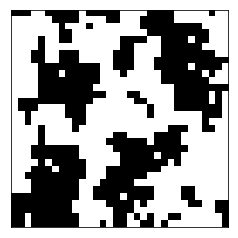

In [7]:
model = IsingModel(32, J=1.0, H=0.0, beta=1/2.26918531421) #critical temperature
trace = model.trace(N=10**4, burn_in=10**3)
model.draw();

# Phase transition in the 2D Ising Magnet

Recall that at a phase transition, one or more derivatives of the partition function are discontinuous.

![](images/ising_sim.png)

# The Spin Glass

We can generalize the Ising model to a system where spins are connected to each other randomly

In [8]:
class SpinGlass:
    
    def __init__(self, graph, J=1.0, spins=None, beta=1.0, H=0.0, p=0.2):
        self.lattice = graph
        self.N =len(graph)
        self.H = H
        self.beta = beta
        self.kT = 1 / beta
        self.J  = J
        self._init_spins(spins)
            
    def _init_spins(self, spins):
        if spins is None:
            spins = (2*(np.random.randn(self.N) > 0) - 1)
        for n, s in zip(self.lattice, spins):
            self.lattice.node[n]["spin"] = s
        
    def draw_network(self, node_size=300, ax=None, how="circular"):
        dx = 1.0#/ self.N
        if ax is None: fig, ax = plt.subplots()
        colors = ["r" if self.lattice.node[n]["spin"] > 0 
                      else "w" for n in self.lattice] 
        if how=="circular":
            nx.draw_circular(self.lattice, 
                             node_color=colors, 
                             node_size=node_size, 
                             with_labels=False, 
                             ax=ax)
        else:
            nx.draw_networkx(self.lattice, 
                             node_color=colors, 
                             node_size=node_size, 
                             with_labels=False, 
                             ax=ax)
        ax.set_yticks([])
        ax.set_xticks([])
        return ax
    
    def trace(self, N=10**5, thin=1000, burn_in=10**3):
        energies = []
        magnetizations = []
        for j in range(burn_in):
            self.metropolis_hastings_step()
        for i in range(N):
            self.metropolis_hastings_step()
            if i % thin == 0:
                energies.append(self.energy())
                magnetizations.append(self.magnetization())
                
        return {"energy" : np.array(energies), 
                "magnetization" : np.array(magnetizations)}
            
        
    def spin_matrix(self):
        M = np.zeros((self.N, self.N))
        for (i, j), s in self.lattice.node.items():
            M[i, j] = s["spin"]
        return M
    
    def draw(self, ax=None):
        M = self.spin_matrix()
        if ax is None: fig, ax = plt.subplots()
        ax.imshow(M, interpolation="none", cmap=cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
        return ax
    
    def flip_spin(self, m):
        self.lattice.node[m]["spin"] *= -1
    
    def energy(self):
        field_energy = self.H * sum(self.lattice.node[m]["spin"] 
                                    for m in self.lattice.nodes())
        interactions = self.J * sum(self.lattice.node[m]["spin"] * \
                                    self.lattice.node[n]["spin"] 
                               for m, n in self.lattice.edges())
        return -(field_energy + interactions)
    
    def magnetization(self):
        return np.sum([self.lattice.node[i]["spin"] 
                       for i in self.lattice.nodes()]) / float(self.N)
    
    def metropolis_hastings_step(self):
        m = np.random.randint(0, self.N)
        s = self.lattice.node[m]["spin"]
        neighbors = self.lattice.neighbors(m)
        deltaE = 2 * s * ( self.J * sum(self.lattice.node[n]["spin"] 
                                         for n in neighbors) + self.H )
        if deltaE < 0:
            self.flip_spin(m)
        else:
            p = np.exp(-self.beta*deltaE)
            if np.random.uniform(0,1) < p:
                self.flip_spin(m)

Net magnetization per spin: 0.62


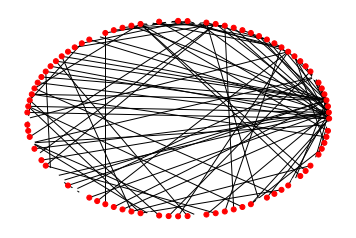

In [9]:
graph = nx.barabasi_albert_graph(100, 1)
sg = SpinGlass(graph, beta=1.0, H=0.0)
for i in range(10000):
    sg.metropolis_hastings_step()
sg.draw_network(how="circular", node_size=25);
print("Net magnetization per spin:", sg.magnetization())

# Spontaneous Magnetization in a Spin Glass

0.26
0.18


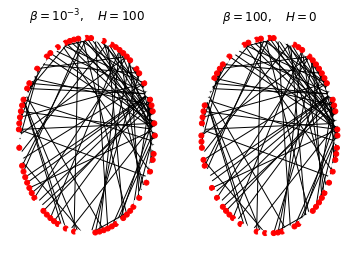

In [10]:
graph = nx.barabasi_albert_graph(100, 1)
sg = SpinGlass(graph, beta=1e-3, H=100.0)
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(10000):
    sg.metropolis_hastings_step()
sg.draw_network(how="circular", node_size=25, ax=ax[0]);

print(sg.magnetization())
sg.H = 0
sg.beta = 100.0

for i in range(10000):
    sg.metropolis_hastings_step()
sg.draw_network(how="circular", node_size=25, ax=ax[1])

ax[0].set_title(r"$\beta=10^{-3},\ \ \  H = 100$")
ax[1].set_title(r"$\beta=100,\ \ \  H = 0$");

print(sg.magnetization())

# Some disappointing things

![](images/ising_np_complete.png)
![](images/spin_glass_np_hard.png)

# The Hopfield Network

Spin glasses have many low-energy states and rugged landscapes.  Hopfield had a great idea: use these to embed memories.  The idea is to construct a spin glass where "memories" are low energy states.

Any memories can be encoded as binary strings that correspond to firing patterns of neurons, for example:

$$V_1 = 10110100,\ \ \ \ \ \ \ V_2 = 00101001 , \ \ \ \ V_3 = 11110000 ,\ \ \  .....$$

We can turn these into vectors like this

$$111000 \to [+1, +1, +1 -1, -1, -1]$$

If we want to store the memory $111000$, then what would it mean to remember it from incomplete or corrupted information?

That means that if we observe $111001$, we would like our dynamics to evolve to $111000$.

**We want a spin glass that has the memories as local minima!**

If we can find a spin glass with these as local minima, then we can imagine rolling nearby strings down the energy landscape until they reach the memory.

![Source: Nonequilibrium landscape theory of neural networks](images/energy_landscape.png)
*Source: Nonequilibrium landscape theory of neural networks*


# The memory problem redefined

So now we have two questions:

1. How can we make an energy landscape to store memories?
2. How can we roll nearby points down to local minima?


## Making the spin glass
To come up with the weights between the spins, we use **Hebbian learning**.  This is based on the premise that when two neurons fire together, the connection between them is strengthened.

$$w_{ij} \propto Corr(x_i, x_j)$$

This defines a $k \times k$ weight matrix $T$, where $k$ is the length of the strings.  We set the diagonal equal to zero.

## Rolling the memory down the hill

Recall the Hamiltonian

$$\mathcal{H}(\ \vec{s}; J) = -\sum_{i,\ j}J_{ij} s_i s_j$$

It is convenient to write this as

$$\mathcal{H}(\ \vec{s}; J) = -\frac{1}{2}\textbf{s}^T \textbf{J} \textbf{s}$$


Iterate through neurons (or spins, if you like) **asychronously** with the following rule

$$s_i = +1 \text{      if       } \sum_j J_{ij} s_i s_j > 0$$
$$s_i = -1 \text{      if       } \sum_j J_{ij} s_i s_j \le 0$$

It can be shown that updating the neurons this way can never increase the energy; it will always stay the same or go down.

In [11]:
 def random_binary_string(N):
    return "".join(np.random.choice(["0", "1"], 
                                    p=[0.5,0.5]) 
                   for _ in range(N))

def flip_random_bit(string):
    newS = list(string)
    i = random.choice(range(len(newS)))
    newS[i] = str(int(not (int(newS[i]))))
    return "".join(newS)

def flip_random_bits(string, N):
    new_string = "".join(list(string))
    for i in range(N):
        new_string = flip_random_bit(new_string)
    return new_string

def str2v(s):
    return 2*np.array(list(s), dtype=int) - 1

def v2str(V):
    return "".join([str(int(v_i > 0)) for v_i in V])

def weight_matrix(memories):
    states = list(map(str2v, memories))
    N = len(states[0])
    W = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            for s in states:
                W[i,j] += s[i]*s[j]    
    return (W + W.T) / float(N)

def closest_minimum(s, W, maxiter=10**2, bias=0.0):
    minE = np.inf
    s_new = "".join(s_i for s_i in s)
    for i in range(maxiter):
        s_new = update_step(s_new, W)
        if energy(s_new, W) -  energy(s, W) > 2*np.finfo(np.float64).eps:
            raise Exception("WTF")
        if energy(s_new, W) <= minE:
            minE = energy(s_new, W)
            s_best = "".join(s_i for s_i in s_new)
        if energy(s_new, W) ==  energy(s, W):
            break
    return s_best

def update_step(s, W, bias=0):
    V = str2v(s)
    for i in range(len(V)):
        V[i] = 2*int(np.dot(W[i,:], V) > bias) - 1
    return v2str(V)
        
def energy(s, W):
    V = str2v(s)
    return -0.5 * V.T.dot(W).dot(V)

def plot_string_to_digit(s, ax=None):
    X = decode_image_string(s).reshape(50,50)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, interpolation="none", cmap=cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    return X
    
def encode_pixel(num, how="thresh:"):        
    return str(int(num))
    
def decode_image_string(s):
    L = list(map(int, list(s)))
    #X = np.zeros(len(L))
    return np.array(L)

def encode_image(img):
    return reduce(lambda x, y: x+y, map(encode_pixel, img))

def standardize_image(img, size=(50,50), thresh=100, plot=False, flatten=True):
    import os
    img = "images" + os.sep + img
    image = misc.imresize(misc.imread(img), size, interp="nearest")
    image = (1 * (image < thresh))[:,:,0]
    if plot: plt.imshow(image, cmap=cm.binary);
    if flatten:
        return image.flatten()
    else:
        return image

# Recalling images in the presence of noise

/Users/williamtrenfield/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/williamtrenfield/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


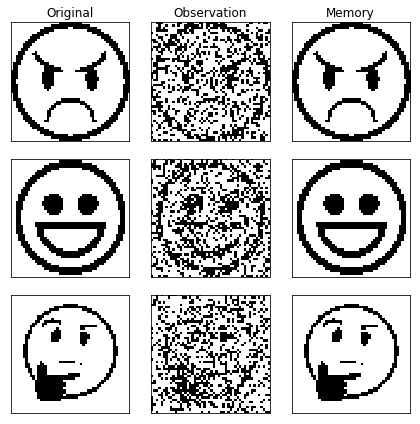

In [12]:
images = list(map(standardize_image, 
                  ["mad_emoji.jpg", 
                   "happy_emoji.png", 
                   "think_emoji.png"])
             )

strings = list(map(encode_image, images))

T = weight_matrix(strings)

fig, ax = plt.subplots(nrows=len(strings), ncols=3, figsize=(6,6))
for i, x in enumerate(strings):
    #x = strings[i]
    noisy_x = flip_random_bits(x, 1000)
    x_hat = closest_minimum(noisy_x, T, bias=0.0, maxiter=100)
    plot_string_to_digit(x, ax[i][0])
    plot_string_to_digit(noisy_x, ax[i][1])
    plot_string_to_digit(x_hat, ax[i][2])
ax[0][0].set_title("Original")
ax[0][1].set_title("Observation")
ax[0][2].set_title("Memory")
fig.tight_layout()

# Recalling images from incomplete data

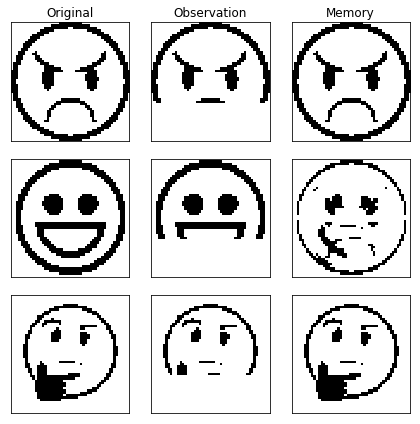

In [13]:
fig, ax = plt.subplots(nrows=len(strings), ncols=3, figsize=(6,6))
for i, x in enumerate(strings):
    #x = strings[i]
    noisy_x = x[:1700] + (800*"0")
    x_hat = closest_minimum(noisy_x, T, maxiter=100)
    plot_string_to_digit(x, ax[i][0])
    plot_string_to_digit(noisy_x, ax[i][1])
    plot_string_to_digit(x_hat, ax[i][2])
ax[0][0].set_title("Original")
ax[0][1].set_title("Observation")
ax[0][2].set_title("Memory")
fig.tight_layout()

# Overloading the network

/Users/williamtrenfield/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/williamtrenfield/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


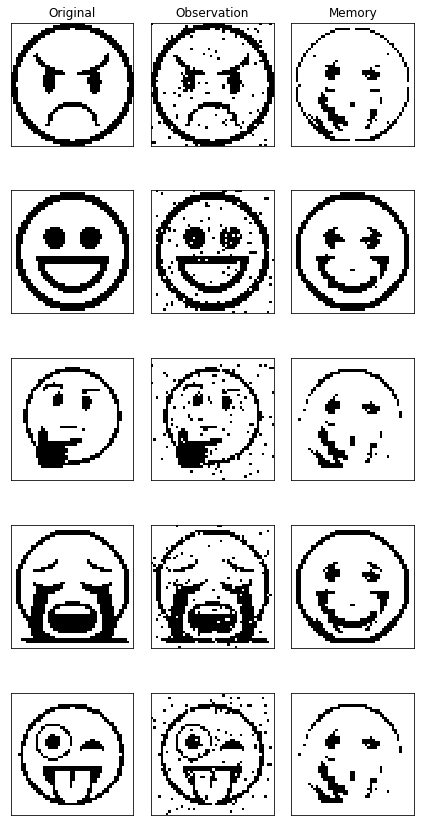

In [14]:
images = list(map(standardize_image, ["mad_emoji.jpg", 
                                      "happy_emoji.png", 
                                      "think_emoji.png",
                                      "sad_emoji.png", 
                                      "goofy_emoji.png"])
             )

strings = list(map(encode_image, images))

T = weight_matrix(strings)

fig, ax = plt.subplots(nrows=len(strings), ncols=3, figsize=(6,12))
for i, x in enumerate(strings):
    #x = strings[i]
    noisy_x = flip_random_bits(x, 100)
    x_hat = closest_minimum(noisy_x, T, bias=0.0, maxiter=10)
    plot_string_to_digit(x, ax[i][0])
    plot_string_to_digit(noisy_x, ax[i][1])
    plot_string_to_digit(x_hat, ax[i][2])
ax[0][0].set_title("Original")
ax[0][1].set_title("Observation")
ax[0][2].set_title("Memory")
fig.tight_layout()